# Diurnal variations of wind 


This notebook look into the wind velocity parameters from the model outputs 

In [62]:
import xarray as xr
from pathlib import Path
import pandas as pd
import intake
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import easygems.healpix as egh
import numpy as np

In [2]:
data_2d_z2 = "/g/data/qx55/uk_node/glm.n2560_RAL3p3/data.healpix.PT1H.z6.zarr" #PT1H is hourly data
ds = xr.open_zarr(data_2d_z2)
ds

<xarray.Dataset> Size: 49GB
Dimensions:  (cell: 49152, time: 10489)
Coordinates:
  * cell     (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs      float64 8B ...
  * time     (time) datetime64[ns] 84kB 2020-01-20 ... 2021-04-01
Data variables: (12/24)
    clivi    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clt      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    clwvi    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hflsd    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    hfssd    (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    huss     (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ...       ...
    rsut     (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    rsutcs   (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    tas      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    ts       (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    uas      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
    vas      (time, cell) float32 2GB dask.array<chunksize=(64, 16384), meta=np.ndarray>
Attributes:
    Met Office DYAMOND3 simulations:  A group of experiments have been conduc...
    bounds:                           {'lower_left_lat': -90, 'lower_left_lon...
    latitiude_convention:             [-90, 90]
    longitude_convention:             [0, 360]
    regional:                         False
    simulation:                       glm.n2560_RAL3p3
    simulation_description:           The MetUM uses a regular lat-lon grid, ...

In [7]:
# slect the wind data u and v components
u=ds.uas.sel(time=slice("2020-01-01", "2021-01-01"))
v=ds.vas.sel(time=slice("2020-01-01", "2021-01-01"))
velocity = (u**2 + v**2)**0.5

In [44]:
u

<xarray.DataArray 'uas' (time: 8352, cell: 49152)> Size: 2GB
dask.array<getitem, shape=(8352, 49152), dtype=float32, chunksize=(64, 16384), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs      float64 8B ...
  * time     (time) datetime64[ns] 67kB 2020-01-20 ... 2021-01-01T23:00:00
Attributes:
    STASH:          [1, 3, 225]
    UM_name:        x_wind
    grid_mapping:   healpix_nested
    healpix_zoom:   6
    long_name:      eastward_wind
    source:         Data from Met Office Unified Model
    standard_name:  x_wind
    um_version:     13.5
    units:          m s-1

In [45]:

def monthly_hourly_average(data):
    """
    Compute the time average for each hour of the day across all days, separately for each month.
    """
    # Group by month, then by hour, and compute the mean over time within each group
    monthly_hourly_avg = data.groupby('time.month').apply(lambda x: x.groupby('time.hour').mean('time'))
    
    return monthly_hourly_avg


In [46]:
# get the average velocities 
hourly_avg_u = monthly_hourly_average(u)  
hourly_avg_v = monthly_hourly_average(v)
hourly_avg_velocity = monthly_hourly_average(velocity)
hourly_avg_velocity

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Only found a single cohort. 'map-reduce' is preferred.
INFO:flox:_choose_method: method is None
INFO:flox:_choose_method: choosing preferred_method=map-reduce
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: reindex is True
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None

<xarray.DataArray (month: 12, cell: 49152, hour: 24)> Size: 57MB
dask.array<transpose, shape=(12, 49152, 24), dtype=float32, chunksize=(1, 16384, 24), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs      float64 8B nan
  * hour     (hour) int64 192B 0 1 2 3 4 5 6 7 8 ... 15 16 17 18 19 20 21 22 23
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

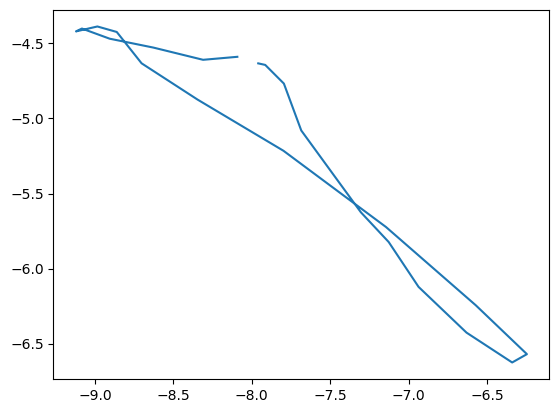

In [47]:
# plot the average wind components of a single cell for averages of a month 
plt.plot(hourly_avg_u.isel(cell=5,month=1),hourly_avg_v.isel(cell=5,month=1))

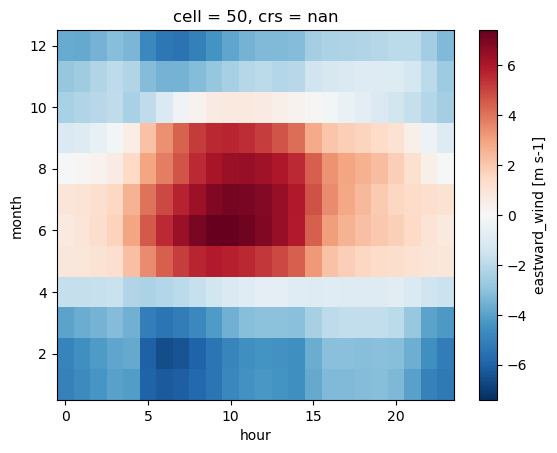

In [48]:
# plot the average values for a singles cell.
hourly_avg_u.isel(cell=50).plot() 

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]


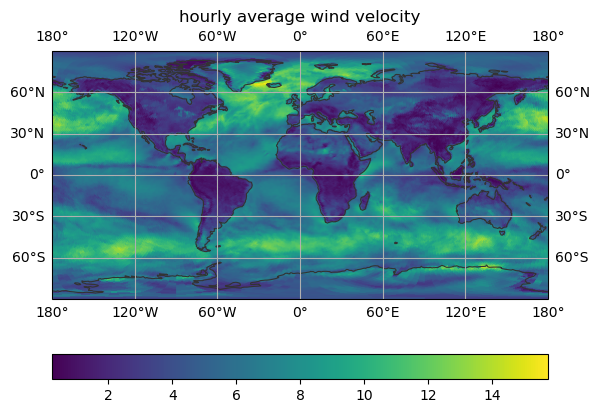

In [49]:
# Plotting lat/lon values over the grid
projection=ccrs.PlateCarree(central_longitude=0.0)

ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(hourly_avg_velocity.isel(month=0,hour=0), ax=ax, add_coastlines=True)
ax.set_title(f'hourly average wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 118 times more chunks
  return self.array[key]


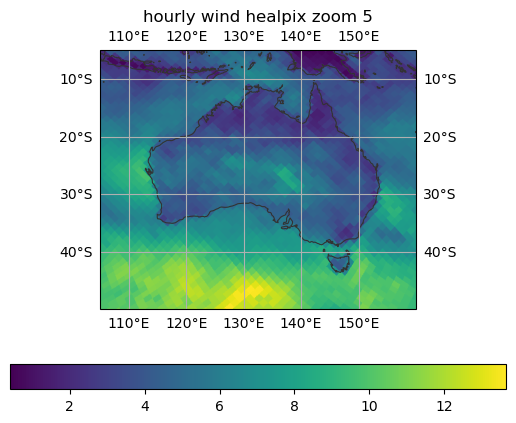

In [50]:
# Plotting the above, over Australia

# Note - we still have to use the egh wrapper functions to plot the healpix gridded data
# onto a lat/lon grid
projection = ccrs.PlateCarree(central_longitude=0)

ax = egh.create_geoaxis(add_coastlines=True,projection=projection)

ax.set_extent([105, 160,-50, -5], crs=ccrs.PlateCarree())
im = egh.healpix_show(hourly_avg_velocity.isel(month=0,hour=0), ax=ax)
#ax.coastlines()
ax.set_title(f'hourly wind healpix zoom 5')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### calculate the max min values and amplitud of the diurnal variations

In [51]:
monthly_max=hourly_avg_velocity.max(dim='hour') #looking at max values for each months 
#monthly_max.isel(cell=0,month=1).plot()
monthly_max

<xarray.DataArray (month: 12, cell: 49152)> Size: 2MB
dask.array<_nanmax_skip-aggregate, shape=(12, 49152), dtype=float32, chunksize=(1, 16384), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs      float64 8B nan
  * month    (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12

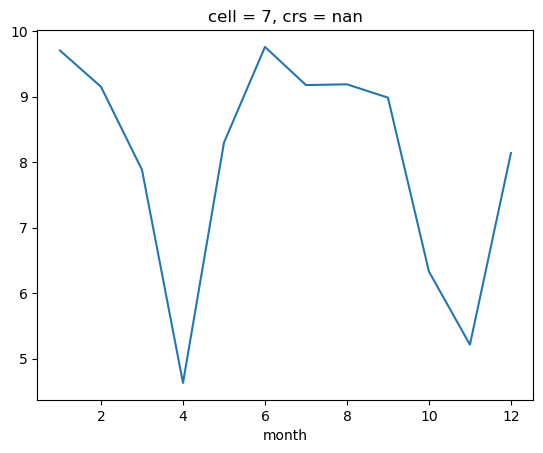

In [52]:
monthly_max.isel(cell=7).plot()

In [53]:
#taking the maximum and minimums for whole dataset across hours and months. each cell has one value
avg_max = hourly_avg_velocity.max(dim='hour').max(dim='month')
avg_min = hourly_avg_velocity.min(dim='hour').min(dim='month') 
avg_min
 

<xarray.DataArray (cell: 49152)> Size: 197kB
dask.array<_nanmin_skip-aggregate, shape=(49152,), dtype=float32, chunksize=(16384,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs      float64 8B nan

In [55]:
avg_max.isel(cell=0).values #checking the max value for single cell

array(10.817893, dtype=float32)

In [56]:
# getting the amplitude
max_min_diff = avg_max - avg_min
max_min_diff

<xarray.DataArray (cell: 49152)> Size: 197kB
dask.array<sub, shape=(49152,), dtype=float32, chunksize=(16384,), chunktype=numpy.ndarray>
Coordinates:
  * cell     (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs      float64 8B nan

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/indexing.py:1620: PerformanceWarning: Slicing with an out-of-order index is generating 449 times more chunks
  return self.array[key]


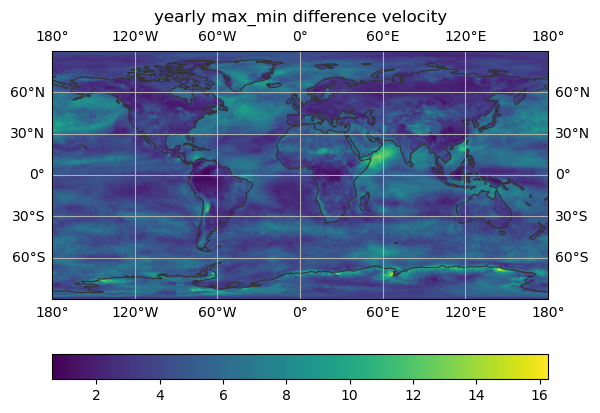

In [57]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_min_diff, ax=ax, add_coastlines=True)
ax.set_title(f'yearly max_min difference velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

### picking the timestamp for max valocity

In [58]:

#  Reshape to stack (month, hour) into a single dimension
uas_stacked = hourly_avg_velocity.stack(time_combo=("month", "hour"))
uas_stacked

<xarray.DataArray (cell: 49152, time_combo: 288)> Size: 57MB
dask.array<reshape, shape=(49152, 288), dtype=float32, chunksize=(16384, 24), chunktype=numpy.ndarray>
Coordinates:
  * cell        (cell) int64 393kB 0 1 2 3 4 5 ... 49147 49148 49149 49150 49151
    crs         float64 8B nan
  * time_combo  (time_combo) object 2kB MultiIndex
  * month       (time_combo) int64 2kB 1 1 1 1 1 1 1 1 ... 12 12 12 12 12 12 12
  * hour        (time_combo) int64 2kB 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23

In [67]:
# Find the index of the max along the combined dimension, for each cell. this is only an id
max_idx = uas_stacked.argmax(dim="time_combo")
max_idx.values

array([ 20,  18,  14, ..., 205, 205, 206])

In [68]:
# this function unravvel the id of the maximum value to the hour and month.
month_indices, hour_indices = np.unravel_index(max_idx.values, (12, 24)) #

In [69]:
# Also get the max value for each cell
max_val = uas_stacked.max(dim="time_combo")

In [70]:
# save the max value and the timestamps into a new dataset
max_values_ds = xr.Dataset({
    "max_value": (["cell"], max_val.values),
    "month_of_max": (["cell"], month_indices),
    "hour_of_max": (["cell"], hour_indices),
})

In [71]:
max_values_ds

<xarray.Dataset> Size: 983kB
Dimensions:       (cell: 49152)
Dimensions without coordinates: cell
Data variables:
    max_value     (cell) float32 197kB 10.82 11.26 9.587 ... 9.367 7.113 8.899
    month_of_max  (cell) int64 393kB 0 0 0 0 0 0 0 5 5 5 ... 8 8 8 8 8 8 8 8 8 8
    hour_of_max   (cell) int64 393kB 20 18 14 14 18 18 14 ... 13 12 13 13 13 14

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


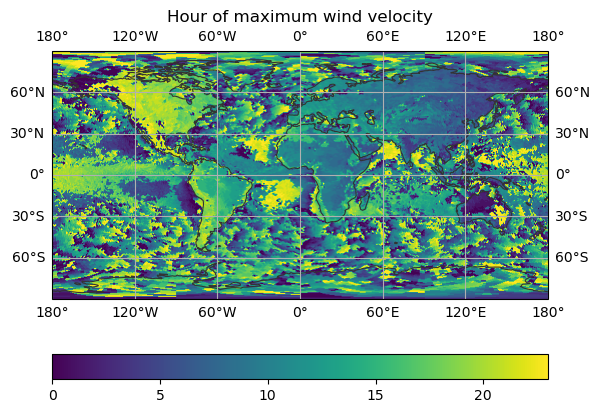

In [72]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds.hour_of_max, ax=ax, add_coastlines=True)
ax.set_title(f'Hour of maximum wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')

In [73]:
from matplotlib.colors import LinearSegmentedColormap

# Create custom colormap: light → dark → light . made this since we are trying to plot the hours of day that are cyclical 
gray_fade = LinearSegmentedColormap.from_list(
    "gray_fade", ["lightgray", "black", "lightgray"]
)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


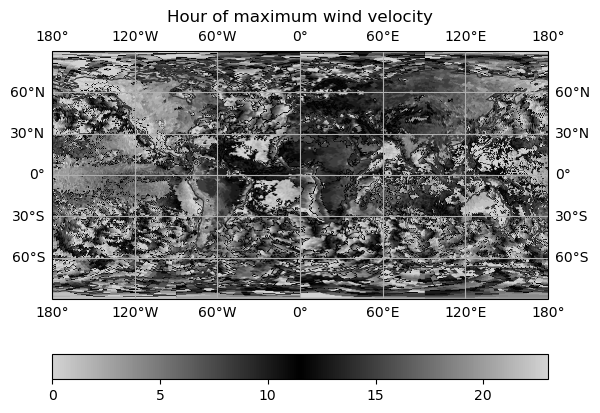

In [74]:
projection=ccrs.PlateCarree(central_longitude=0.0)
ax = egh.create_geoaxis(add_coastlines=True,projection=projection)
im = egh.healpix_show(max_values_ds.hour_of_max, ax=ax, add_coastlines=True,cmap=gray_fade)
ax.set_title(f'Hour of maximum wind velocity')
ax.gridlines(draw_labels=True)
fig=ax.get_figure()
fig.colorbar(im,orientation='horizontal')